# Analysis of Real Data from the PDHD Detector
## **This notebook focuses on the run 32974, collection plane.**
Once you're comfortable with the simplified MC data, the next step is to analyze real data collected by the ProtoDUNE Horizontal Drift (PDHD) detector. 

As a surface detector, PDHD is continuously bombarded by cosmic rays, resulting in multiple overlapping tracks within each recorded event. For these data dead channels (overactivity with no real physical signal) have already been masked.

In [3]:
import uproot #Uproot is a Python library that allows you to read, write, and manipulate ROOT files without requiring ROOT or C++.
import awkward as ak #this is for ragged data handling, which is common in particle physics data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
# %matplotlib widget 
warnings.filterwarnings('ignore') # Ignore warnings for cleaner output

filepath = "../data/pdhd_run032974_tps.root"    

with uproot.open(filepath) as file:
    tree = file["triggerana/tree"]  # Adjust the path if your tree is elsewhere
    print(tree.keys())  # This prints all branch names in the tree

['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC']


In [4]:
#instead of using all the branches, we can specify which ones we want to read
def load_data(filepath, branch_names, max_events=3000):
    """Load data from a ROOT file into a pandas DataFrame."""
    try:
        with uproot.open(filepath) as file:
            tree = file["triggerana/tree"]
            arrays = tree.arrays(branch_names, library="ak", entry_stop=max_events)
            return ak.to_dataframe(arrays)
    except Exception as e:
        print(f"Error loading data from {filepath}: {e}")
        return None

# name of branches in the TTree to read into the pandas df
TP_BRANCHES_df = ['event', 'run', 'subrun', 'TP_channel', 'TP_startT', 'TP_peakT', 'TP_TOT', 'TP_SADC', 'TP_peakADC', 'TP_plane', 'TP_TPC'] #trigger primitives for real data

In [5]:
#Let's load the data from runs
df_32974= load_data(filepath, TP_BRANCHES_df, 10000)
df_32974.run_name = "Cosmic run 32974"

In [6]:
#In this notebook we will try to do some more statystics and use all of them
events = df_32974.event.unique()
print(f"Event {events}")

Event [  8  16  24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144
 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288
 296 304 360 368]


In [7]:
# Global variable for APA ranges
apa_ranges = {
    "APA1": (0, 2560),
    "APA3": (2560, 5120),
    "APA2": (5120, 7680),
    "APA4": (7680, 10240),
}

In [8]:
plane=2

def make_title(run, event, cuts="no cuts"):
    return f"Run {run} | Event {event} | Plane {plane} | {cuts}"

### Characteristics of a single run, single event, collection plane hits of a single TPC. 

In [9]:
#timestamps correspond to microseconds, the big number is the first detection hit in timestamp
# Note: APA1 collection plane is broken so we will not use it in this analysis.

tps_32974 = df_32974
tps_32974.run_name = "Cosmic run 32974"

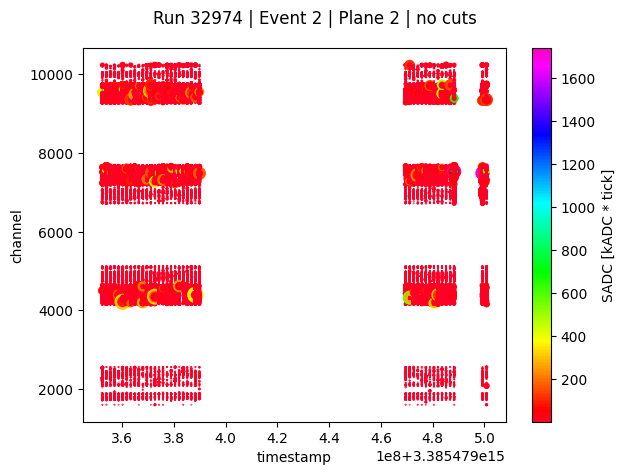

In [10]:
vmin, vmax = 1, (tps_32974["TP_SADC"].max()/1e3)/2
plt.figure()

tps = tps_32974[tps_32974.TP_plane == plane]
tps.run_name = "Cosmic run 32974"
sc = plt.scatter(tps.TP_peakT, tps.TP_channel, s=tps.TP_TOT / 10, c=tps.TP_SADC/1e3, cmap='gist_rainbow', vmin=vmin, vmax=vmax)
plt.xlabel("timestamp")
plt.ylabel("channel")

plt.suptitle(make_title(tps['run'].unique()[0], plane))
cbar = plt.colorbar(sc)
cbar.set_label("SADC [kADC * tick]")
plt.tight_layout()
plt.show()

In [11]:
print(f"TP_SADC: Minimum value {tps['TP_SADC'].min()/1e3}, maximum {(tps['TP_SADC'].max()/1e3)}, mean {tps['TP_SADC'].mean()/1e3}, std deviation {tps['TP_SADC'].std()/1e3}")
print(f"TP_PeakADC: Minimum value {tps['TP_peakADC'].min()}, maximum {(tps['TP_peakADC'].max())}, mean {tps['TP_peakADC'].mean()}, std deviation {tps['TP_peakADC'].std()}")
print(f"TP_TOT: Minimum value {tps['TP_TOT'].min()}, maximum {(tps['TP_TOT'].max())}, mean {tps['TP_TOT'].mean()}, std deviation {tps['TP_TOT'].std()}")


TP_SADC: Minimum value 0.061, maximum 3476.412, mean 4.431609466048282, std deviation 26.564154887469076
TP_PeakADC: Minimum value 61, maximum 15886, mean 393.2983097260657, std deviation 445.1967497902622
TP_TOT: Minimum value 1, maximum 1171, mean 13.815287995808866, std deviation 18.607527684417374


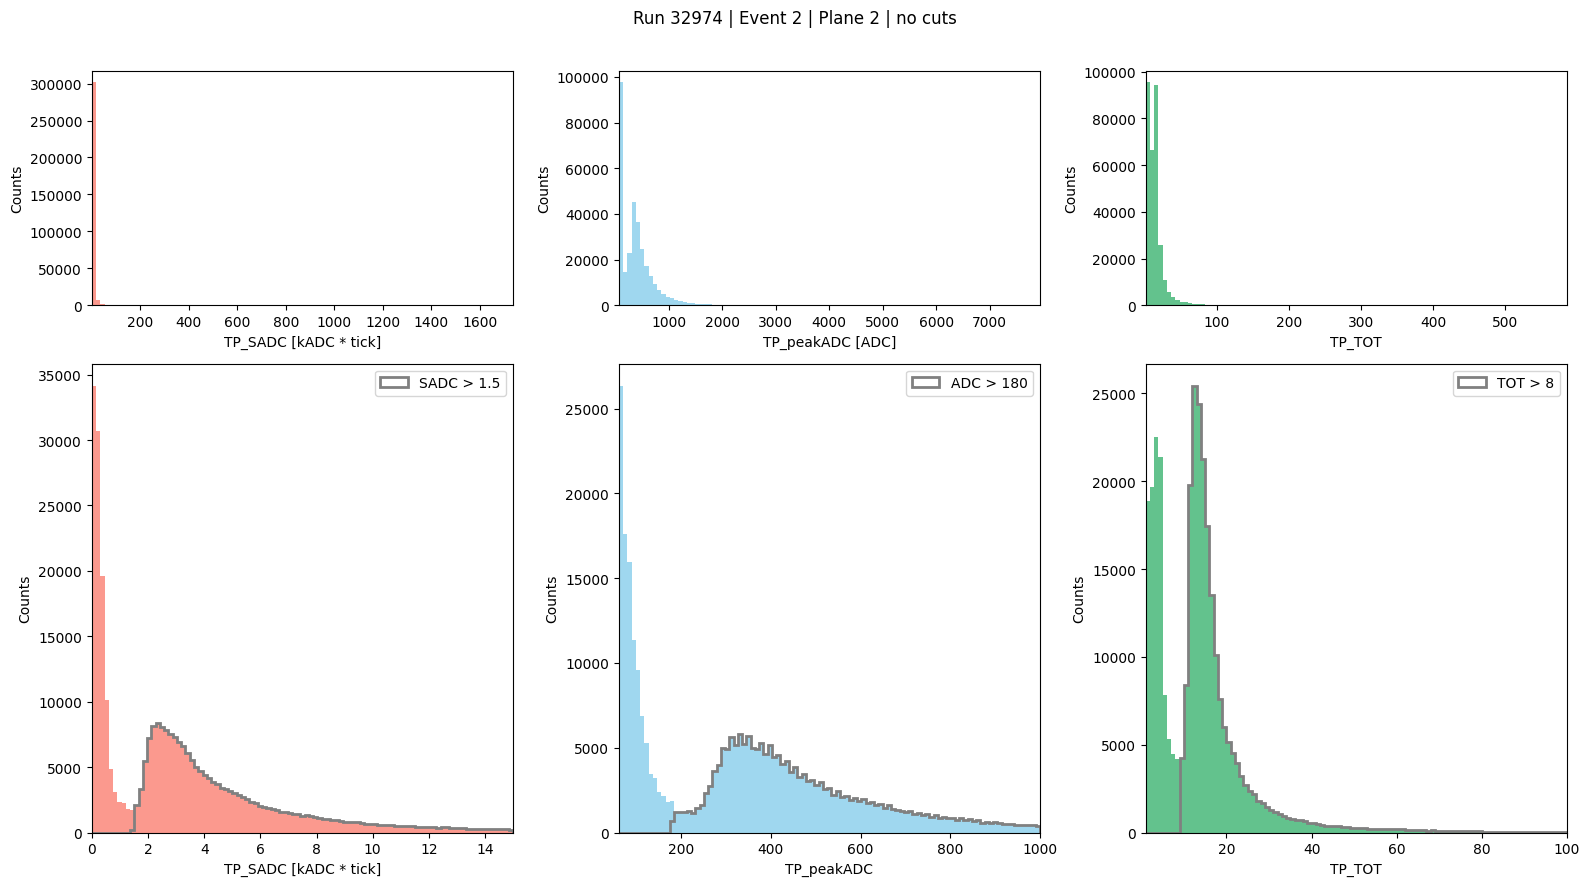

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9), gridspec_kw={'height_ratios': [1, 2]})

plt.suptitle(make_title(tps['run'].unique()[0], plane))

# 1. TP_SADC
bins_sadc = np.linspace(tps['TP_SADC'].min()/1e3, tps['TP_SADC'].max()/2e3, 100)
axs[0, 0].hist(tps['TP_SADC']/1e3, bins=bins_sadc, alpha=0.8, color='salmon')
axs[0, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[0, 0].set_ylabel('Counts')
axs[0, 0].set_xlim(bins_sadc[0], bins_sadc[-1])

mask_sadc = (tps['TP_SADC']/1e3 >= 0) & (tps['TP_SADC']/1e3 <= 15)
tps_zoom_sadc = tps[mask_sadc]
bins_sadc_zoom = np.linspace(0, 15, 100)
axs[1, 0].hist(tps_zoom_sadc['TP_SADC']/1e3, bins=bins_sadc_zoom, alpha=0.8, color='salmon')
axs[1, 0].set_xlabel('TP_SADC [kADC * tick]')
axs[1, 0].set_ylabel('Counts')
axs[1, 0].set_xlim(bins_sadc_zoom[0], bins_sadc_zoom[-1])

threshold_sadc = 1.5
sadc_cut = tps_zoom_sadc[tps_zoom_sadc['TP_SADC']/1e3 > threshold_sadc]
axs[1, 0].hist(sadc_cut['TP_SADC']/1e3, bins=bins_sadc_zoom, histtype='step', color='gray', linewidth=2, label='SADC > 1.5')
axs[1, 0].legend()

# 2. TP_peakADC
bins_adc = np.linspace(tps['TP_peakADC'].min(), tps['TP_peakADC'].max()/2, 100)
axs[0, 1].hist(tps['TP_peakADC'], bins=bins_adc, alpha=0.8, color='skyblue')
axs[0, 1].set_xlabel('TP_peakADC [ADC]')
axs[0, 1].set_ylabel('Counts')
axs[0, 1].set_xlim(bins_adc[0], bins_adc[-1])

mask_adc = (tps['TP_peakADC'] >= 61) & (tps['TP_peakADC'] <= 1000)
tps_zoom_adc = tps[mask_adc]
bins_adc_zoom = np.linspace(61, 1000, 100)
axs[1, 1].hist(tps_zoom_adc['TP_peakADC'], bins=bins_adc_zoom, alpha=0.8, color='skyblue')
axs[1, 1].set_xlabel('TP_peakADC')
axs[1, 1].set_ylabel('Counts')
axs[1, 1].set_xlim(bins_adc_zoom[0], bins_adc_zoom[-1])

threshold_adc = 180
adc_cut = tps_zoom_adc[tps_zoom_adc['TP_peakADC'] > threshold_adc]
axs[1, 1].hist(adc_cut['TP_peakADC'], bins=bins_adc_zoom, histtype='step', color='gray', linewidth=2, label='ADC > 180')
axs[1, 1].legend()

# 3. TP_TOT
bins_tot = np.linspace(tps['TP_TOT'].min(), tps['TP_TOT'].max()/2, 100)
axs[0, 2].hist(tps['TP_TOT'], bins=bins_tot, alpha=0.8, color='mediumseagreen')
axs[0, 2].set_xlabel('TP_TOT')
axs[0, 2].set_ylabel('Counts')
axs[0, 2].set_xlim(bins_tot[0], bins_tot[-1])

mask_tot = (tps['TP_TOT'] >= 1) & (tps['TP_TOT'] <= 100)
tps_zoom_tot = tps[mask_tot]
bins_tot_zoom = np.linspace(1, 100, 100)
axs[1, 2].hist(tps_zoom_tot['TP_TOT'], bins=bins_tot_zoom, alpha=0.8, color='mediumseagreen')
axs[1, 2].set_xlabel('TP_TOT')
axs[1, 2].set_ylabel('Counts')
axs[1, 2].set_xlim(bins_tot_zoom[0], bins_tot_zoom[-1])

threshold_tot = 8
tot_cut = tps_zoom_tot[tps_zoom_tot['TP_TOT'] > threshold_tot]
axs[1, 2].hist(tot_cut['TP_TOT'], bins=bins_tot_zoom, histtype='step', color='gray', linewidth=2, label='TOT > 8')
axs[1, 2].legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

- The small bump is connected to the actual presence of MIP

- The noise we are seeing i the small contribution of natural radioactivity of Liquid Argon 39

    Apparently the same cuts we used for one single event work in this case

Event duration: 1.6919 s


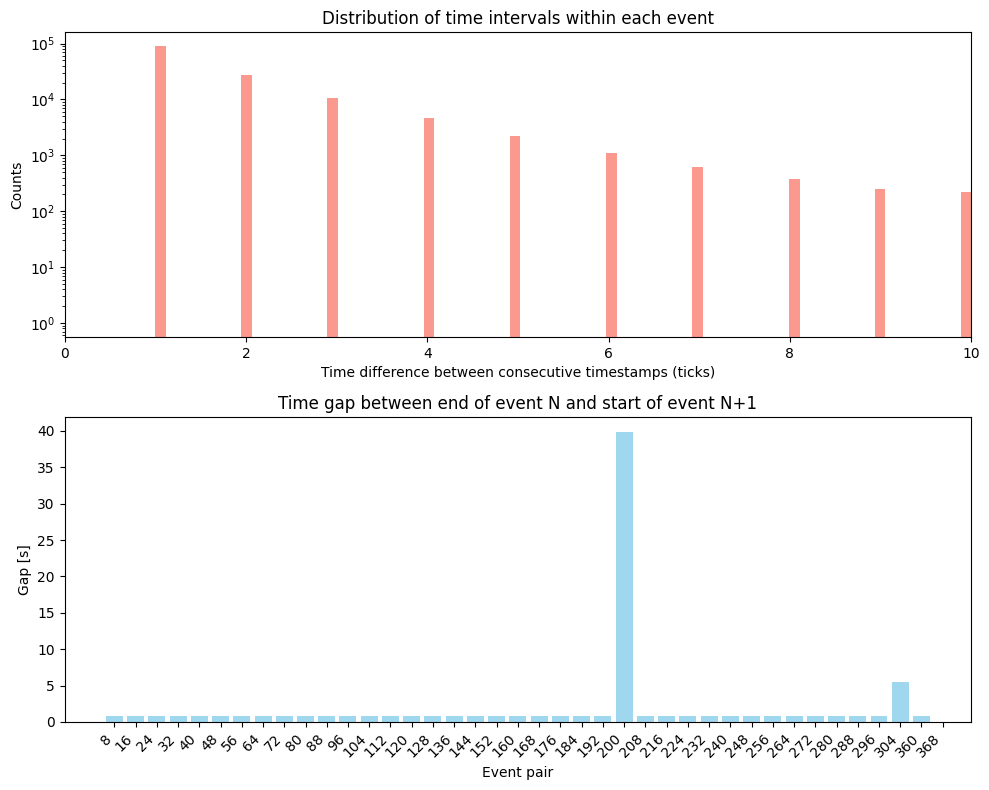

In [13]:
# Store intra-event intervals and inter-event gaps
intra_event_diffs = []
event_firsts = []
event_lasts = []
event_durations_seconds = []

for ev in events:
    ev_df = tps[tps.event == ev]
    ts = np.sort(ev_df["TP_peakT"].unique())
    if len(ts) > 1:
        intra_event_diffs.append(np.diff(ts))
        duration_ticks = ts.max() - ts.min()
        duration_seconds = duration_ticks * 500 / 1e9 #each tick corresponds to 500 ns
        event_durations_seconds.append(duration_seconds)
    event_firsts.append(ts[0])
    event_lasts.append(ts[-1])

# Flatten intra-event diffs for global histogram
intra_event_flat = np.concatenate(intra_event_diffs)

# Compute inter-event gaps
event_firsts = np.array(event_firsts)
event_lasts = np.array(event_lasts)
inter_event_gaps = event_firsts[1:] - event_lasts[:-1]
inter_event_gaps_seconds = inter_event_gaps * 500 / 1e9

print(f"Event duration: {np.mean(intra_event_flat):.4f} s")

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].hist(intra_event_flat, bins=int(2*np.sqrt(len(intra_event_flat))), color='salmon', alpha=0.8, log=True) #y axis in log scale
axs[0].set_title('Distribution of time intervals within each event')
axs[0].set_xlabel('Time difference between consecutive timestamps (ticks)')
axs[0].set_ylabel('Counts')
axs[0].set_xlim(0, 10)

# Bar plot with custom labels for event pairs
axs[1].bar(range(len(inter_event_gaps_seconds)), inter_event_gaps_seconds, color='skyblue', alpha=0.8)
axs[1].set_title('Time gap between end of event N and start of event N+1')
axs[1].set_xlabel('Event pair')
axs[1].set_ylabel('Gap [s]')
axs[1].set_xticks(range(len(events)))
axs[1].set_xticklabels(events, rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Looking into thresholds and noise removal

In [14]:
def plot_TPC_activity(tp_df, thresh, thresh_type="TP_peakADC", vmin=None, vmax=None, show_counts=True):  
    """
    Creates scatter plots showing TP distribution across APAs with optional bar charts for TP counts. 
    Scatter plot point sizes are proportional to TP_TOT/10. Scatter plot colors represent TP_SADC values using 'gist_rainbow' colormap
    Data is filtered based on specified threshold criteria to remove noise.
    Creates 2x2 subplot grid for the 4 APAs in ProtoDUNE. Requires global variable 'apa_ranges' containing APA channel ranges

    ----------
    tp_df : pandas.DataFrame
        DataFrame containing trigger primitive data
        
    thresh : float
        Threshold value for filtering TPs. 
        
    thresh_type : str, optional
        Type of threshold to apply for filtering. Default is "TP_peakADC".
        Options:
        - "TP_peakADC": Filter by peak ADC value
        - "TP_TOT": Filter by time over threshold
        - "TP_SADC": Filter by sum ADC (divided by 1e3 for kADC units)
        
    vmin : float, optional
        Minimum value for colorbar scale in scatter plots. If None, uses data minimum.
        
    vmax : float, optional
        Maximum value for colorbar scale in scatter plots. If None, uses data maximum.
        
    show_counts : bool, optional
        Whether to display bar chart showing TP counts per APA. Default is True.
    """
    global apa_ranges 
    title_prefix = "TP Activity per APA"
    # Filter based on the threshold type
    if thresh_type == "TP_peakADC":
        filtered = tp_df[tp_df.TP_peakADC > thresh]
    elif thresh_type == "TP_TOT":
        filtered = tp_df[tp_df.TP_TOT > thresh]
    elif thresh_type == "TP_SADC":
        filtered = tp_df[tp_df.TP_SADC / 1e3 > thresh]
    else:
        raise ValueError(f"Unknown threshold type: {thresh_type}")

    print(f"Threshold ({thresh_type}): {thresh} (TPs: {len(filtered)}, Retaining {len(filtered)/len(tp_df)*100:.2f}% of raw TP)")
    run_type = tp_df.run_name if hasattr(tp_df, 'run_name') else "unknown_run"
    plot_title = f"{title_prefix} ({run_type}, threshold: {thresh_type} > {thresh})"

    # --- Scatter plots ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    for i, (apa, (start, stop)) in enumerate(apa_ranges.items()):
        ax = axs[i//2][i%2]
        df_apa = filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)]
        sc = ax.scatter(
            df_apa.TP_peakT, df_apa.TP_channel,
            s=df_apa.TP_TOT / 10,
            c=df_apa.TP_SADC,
            cmap="gist_rainbow",
            alpha=0.7,
            edgecolor="none",
            vmin=vmin, vmax=vmax
        )
        ax.set_title(f"{apa} (channels {start}-{stop-1})")
        ax.set_xlabel("timestamp")
        ax.set_ylabel("TP_channel")
        ax.grid(True, linestyle="dotted", alpha=0.5)

    plt.suptitle(f"{plot_title}", fontsize=18)
    fig.colorbar(sc, ax=axs, orientation="vertical", shrink=0.8, label="TP SADC")
    plt.show()

    # --- Bar plot: TP count per APA ---
    if show_counts:
        apa_counts = [
            len(filtered[(filtered.TP_channel >= start) & (filtered.TP_channel < stop)])
            for (start, stop) in apa_ranges.values()
        ]
        plt.figure(figsize=(8, 5))
        plt.bar(apa_ranges.keys(), apa_counts, color='steelblue')
        plt.ylabel("Number of TPs")
        plt.title(f"Total TP Count per APA ({thresh_type} > {thresh})")
        plt.show()

TPs in first block of 100 events
Threshold (TP_SADC): 1.5 (TPs: 5478, Retaining 65.24% of raw TP)


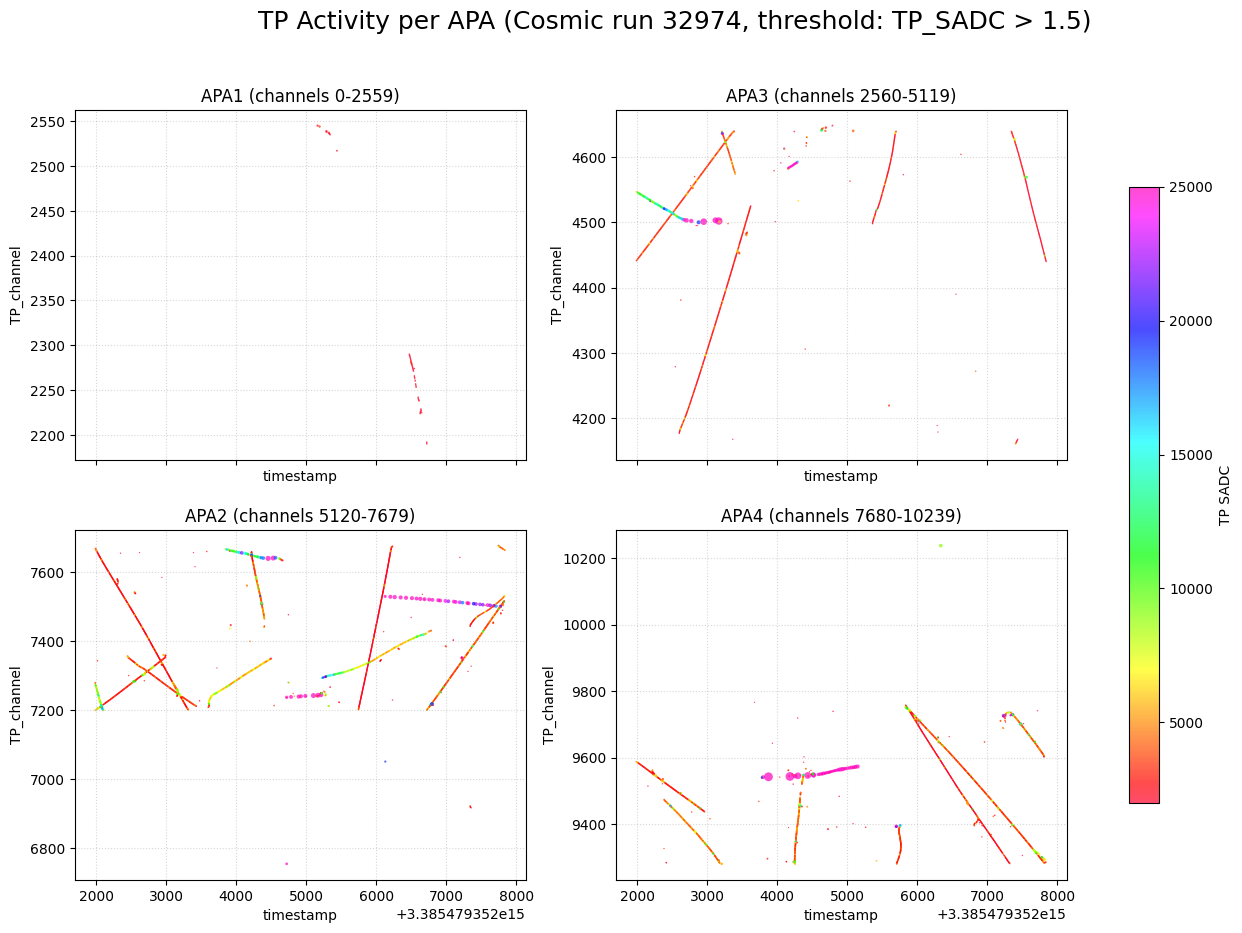

Threshold (TP_peakADC): 180 (TPs: 5553, Retaining 66.13% of raw TP)


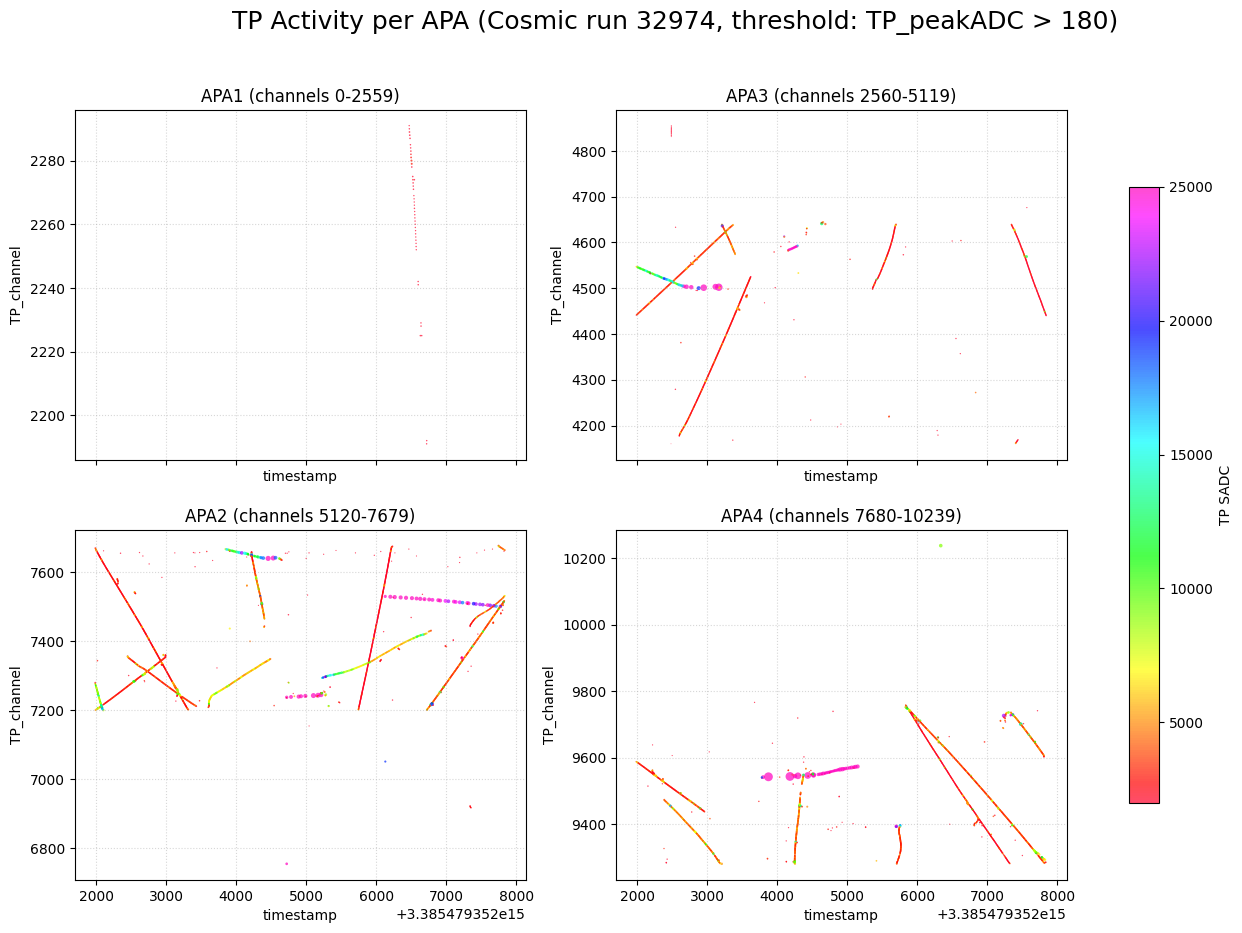

Threshold (TP_TOT): 8 (TPs: 5639, Retaining 67.15% of raw TP)


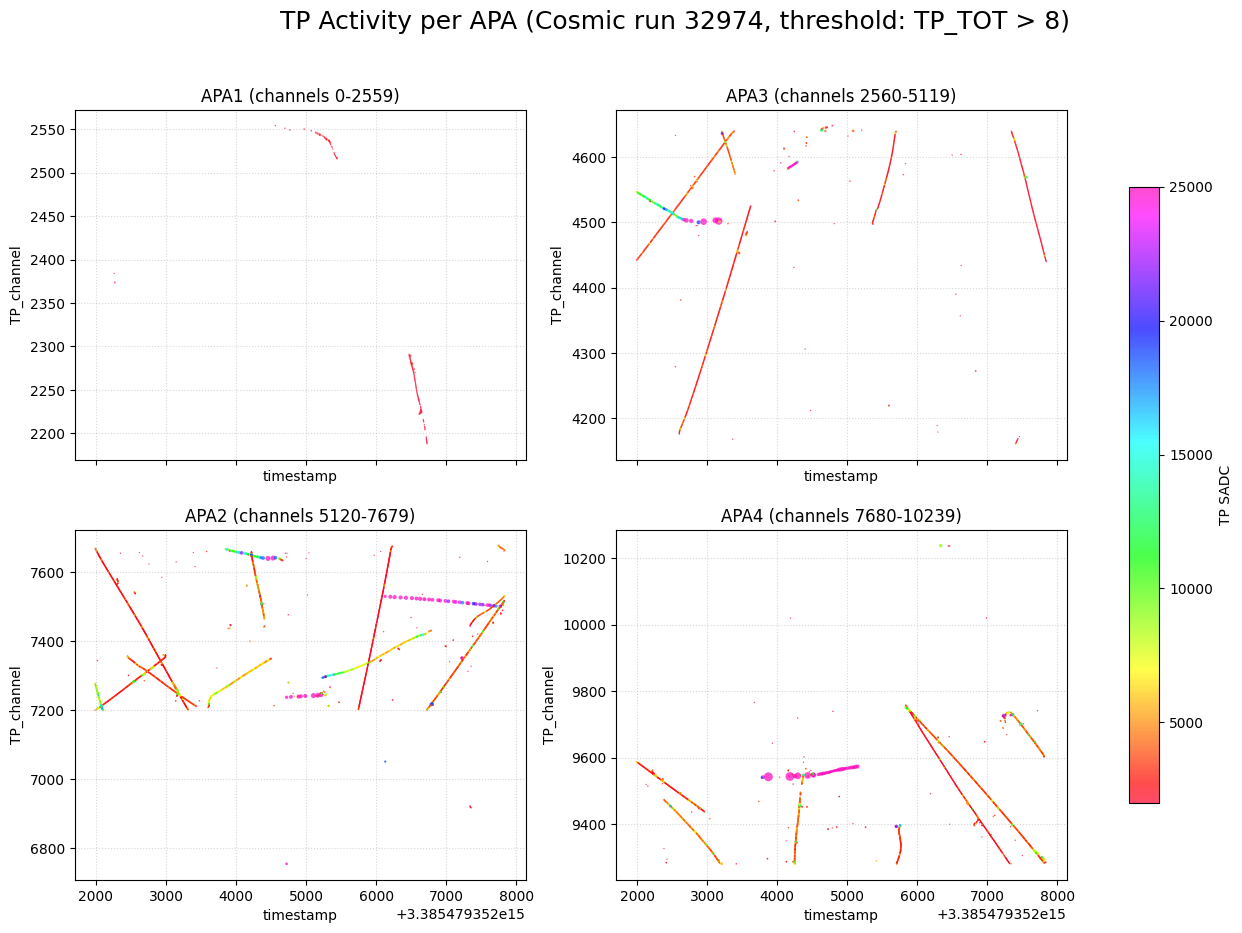

In [15]:
mask = (tps['event'] < 10)
tps_subset = tps[mask]
tps_subset.run_name = tps.run_name

print(f"TPs in first block of 100 events")
# For SADC threshold
plot_TPC_activity(tps_subset, threshold_sadc, 
            vmin=2000, vmax=25000, thresh_type="TP_SADC", show_counts=False)

# For ADC threshold
plot_TPC_activity(tps_subset, threshold_adc, 
            vmin=2000, vmax=25000, thresh_type="TP_peakADC", show_counts=False)

# For TOT threshold
plot_TPC_activity(tps_subset, threshold_tot, 
            vmin=2000, vmax=25000, thresh_type="TP_TOT", show_counts=False)

Big dots are just particles perpedincular to one single channel and therefore releasing a lot of energy in that single channel.

### Spatial distribution

In [16]:
filtered_tps= tps_subset[tps_subset.TP_SADC / 1e3 > threshold_sadc]
filtered_APA2=filtered_tps[(filtered_tps.TP_channel>=apa_ranges["APA2"][0]) & (filtered_tps.TP_channel<apa_ranges["APA2"][1])]
filtered_APA2.run_name = tps.run_name

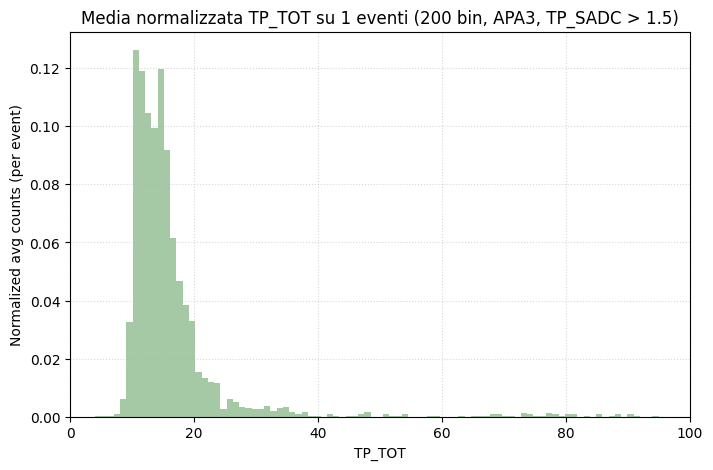

In [20]:
"""
Event-by-Event TP_TOT Distribution Analysis for APA3

This cell performs a detailed statistical analysis of Time Over Threshold (TP_TOT) distributions across multiple cosmic ray events in APA3.

Analysis Strategy:
-----------------
Instead of combining all TP_TOT values from multiple events into a single histogram (which can
smooth out important features), this analysis:

1. Calculates individual normalized histograms for each event
2. Computes the average normalized distribution across all events
3. Creates a 2D heatmap showing TP_TOT distributions per event

Motivation:
---------------------
- Different cosmic ray events may be dominated by different track types or signal populations: aggregating all TP_TOT values can lead to merging and overlapping peaks, 
resulting in a smoother distribution that obscures distinct features.
- This approach wants to reveal common structural features across events

Binning: 200 bins from 0 to 100 TP_TOT units for high resolution
"""

events = np.sort(filtered_APA2['event'].unique())
bins = np.linspace(0, 100, 100)  # 200 bin da 0 a 100
#: in alcuni eventi possono dominare certe tracce o tipologie di segnali che producono un picco, in altri eventi un’altra popolazione. 
# Sommando tutto, i picchi possono “mescolarsi” e sovrapporsi, risultando in una distribuzione più smooth e larga senza due massimi evidenti.

# ================= TP_TOT =================
# Invece di sommare tutte le TP_TOT di 88 eventi insieme, calcola la distribuzione per ogni evento e poi somma (“stacked histogram”) o fai la media delle distribuzioni normalizzate.
# Questo evita che eventi molto “ricchi” dominino la statistica, e fa emergere strutture comuni.
all_event_histos_tot = []
for ev in events:
    dat = filtered_APA2[filtered_APA2['event'] == ev]['TP_TOT']
    counts, _ = np.histogram(dat, bins=bins)
    if counts.sum() > 0:
        counts = counts / counts.sum()
    all_event_histos_tot.append(counts)
mean_histo_tot = np.mean(all_event_histos_tot, axis=0)

plt.figure(figsize=(8,5))
plt.bar((bins[:-1]+bins[1:])/2, mean_histo_tot, width=np.diff(bins), color='darkseagreen', alpha=0.8)
plt.xlabel("TP_TOT")
plt.ylabel("Normalized avg counts (per event)")
plt.title(f"Media normalizzata TP_TOT su {len(events)} eventi (200 bin, APA3, TP_SADC > {threshold_sadc})")
plt.xlim(0, 100)
plt.grid(True, linestyle="dotted", alpha=0.5)
plt.show()

Most of the events seem to be between 11-18, the bimodial distribution that is clear in the case of **RUN_test_event_run.ipynb** is not visibile over here.

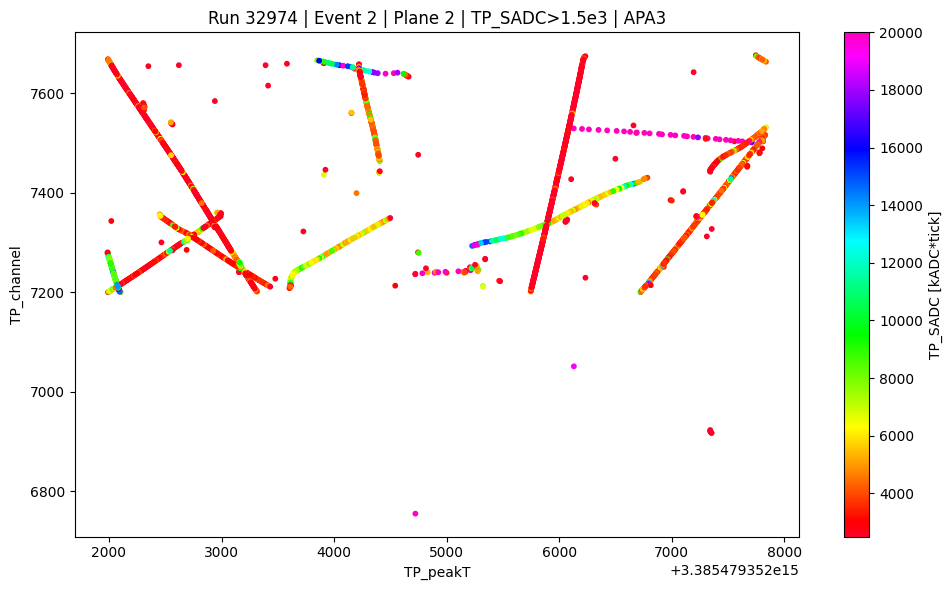

In [19]:
# Parameters
cmap = "gist_rainbow"
vmin, vmax = 2500, 20000

plt.figure(figsize=(10,6))
sc = plt.scatter(
    filtered_APA2["TP_peakT"],
    filtered_APA2["TP_channel"],
    s=10,
    c=filtered_APA2["TP_SADC"],
    cmap=cmap,
    vmin=vmin,
    vmax=vmax
)
plt.title(make_title(tps['run'].unique()[0], plane, "TP_SADC>1.5e3") + " | APA3")
plt.xlabel("TP_peakT")
plt.ylabel("TP_channel")
cbar = plt.colorbar(sc)
cbar.set_label("TP_SADC [kADC*tick]")
plt.tight_layout()
plt.show()